We can do better.

So this time:
- grid search for better parameters

- Can we make a better RF model? **yes**

In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV

In [30]:
def load_data():
    train = pd.read_csv('../input/train.csv')
    test = pd.read_csv('../input/test.csv')
    combined = train.append(test, ignore_index=True).drop(['Id','SalePrice'], axis=1)
    combined = pd.get_dummies(combined)
    combined = combined.fillna(combined.mean())
    y = np.log(train['SalePrice'].values)
    X = combined.iloc[:train.shape[0],:]
    X_submission = combined.iloc[train.shape[0]:,:]
    ids_submission = test['Id'].values
    return y, X, X_submission, ids_submission

In [31]:
# load data
y, X, X_submission, ids_submission = load_data()

In [54]:
model = BaggingRegressor(DecisionTreeRegressor(), random_state=1337)
kf = KFold(10, random_state=1773)

parameters = {
    'base_estimator__max_depth': [14, 15, 16],
    'bootstrap': [False],
    'bootstrap_features': [False],
    'max_features': [0.55, 0.6, 0.65],
    'max_samples': [0.8, 0.90, 1.0],
    'n_estimators': [50]
#     'base_estimator__max_features': None,
#     'base_estimator__max_leaf_nodes': None,
#     'base_estimator__min_impurity_split': 1e-07,
#     'base_estimator__min_samples_leaf': 1,
#     'base_estimator__min_samples_split': 2,
#     'base_estimator__min_weight_fraction_leaf': 0.0,
#     'base_estimator__presort': False,
#     'base_estimator__random_state': 1337,
#     'base_estimator__splitter': 'best',
#     'max_features': 1.0,
#     'max_samples': 1.0,
#     'n_estimators': 10,
#     'n_jobs': 1,
#     'oob_score': False,
#     'random_state': 1337,
#     'verbose': 0,
#     'warm_start': False
}

grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv = kf, n_jobs=8)

In [55]:
#0.1340

In [56]:
%%time
grid.fit(X, y);
print 'score: {:.4f}'.format(np.sqrt(-grid.best_score_))
print 'params:', grid.best_params_

score: 0.1340
params: {'max_samples': 1.0, 'base_estimator__max_depth': 15, 'bootstrap': False, 'n_estimators': 50, 'max_features': 0.6, 'bootstrap_features': False}
CPU times: user 5.8 s, sys: 638 ms, total: 6.44 s
Wall time: 1min 25s


In [19]:
# parameters = {'n_estimators': [50],
#               'max_features': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
#               'max_depth': [7, 9, 11, 13, 15],
#               'min_samples_leaf': [1, 2, 3, 4]}

parameters = {'fit_intercept': [False,True], 
              'normalize': [False,True]}

model = GridSearchCV(LinearRegression(),
                     parameters, 
                     scoring=make_scorer(rmse, greater_is_better=False), 
                     cv=KFold(10, random_state=1773))

In [20]:
%%time
# train grid search
model.fit(X, y)

CPU times: user 3.61 s, sys: 42.2 ms, total: 3.66 s
Wall time: 925 ms


GridSearchCV(cv=KFold(n_splits=10, random_state=1773, shuffle=False),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': [False, True], 'fit_intercept': [False, True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse, greater_is_better=False), verbose=0)

In [21]:
print 'best score:', model.best_score_
print 'best parameters:', model.best_params_

best score: -2507.50296092
best parameters: {'normalize': False, 'fit_intercept': False}


In [22]:
# create submission predictions
preds_submission = model.predict(X_submission)

# save submission
pd.DataFrame({'Id': ids_submission, 'SalePrice': np.exp(preds_submission)})\
  .to_csv('../output/04_gridsearch_RF.csv', index=False)

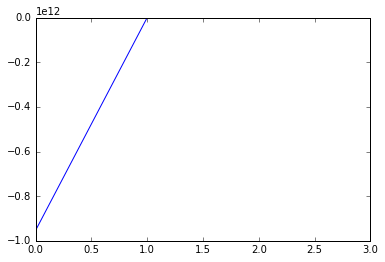

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(np.sort(model.cv_results_['mean_test_score']));